WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
9.902


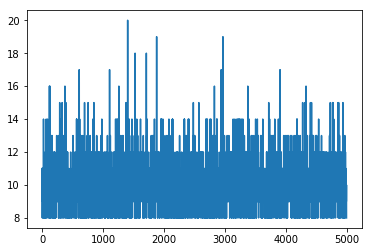

In [5]:
import gym
import numpy as np
import math
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=100)
    display(display_animation(anim, default_mode='loop'))

# Learning parameters
num_episodes = 5000
y = 0.99
e = 0.1
pass_line = 200
x_threshold = 2.4
theta_threshold_radius = 12 * 2 * math.pi / 360


env = gym.make('CartPole-v0')

learning_rate = 0.1
n_hidden = 1024
n_status = 4
n_out = env.action_space.n

graph = tf.Graph()
with graph.as_default():
    
    s_input = tf.placeholder(tf.float32, shape=(n_status))
    
    weights = {
        'hidden': tf.Variable(tf.random_uniform([n_status, n_hidden], 0, 0.01)),
        'out': tf.Variable(tf.random_uniform([n_hidden, n_out], 0, 0.01))
    }
    
    biases = {
        'hidden': tf.Variable(tf.zeros([n_hidden])),
        'out': tf.Variable(tf.zeros([n_out]))
    }
    
    linear = tf.add(tf.matmul(tf.expand_dims(s_input, 0), weights['hidden']), biases['hidden'])
    relu = tf.nn.relu(linear)
    Q_out = tf.add(tf.matmul(relu, weights['out']), biases['out'])
    predict = tf.argmax(Q_out, 1)
    
    Q_new = tf.placeholder(tf.float32, shape=(1, n_out))
    loss = tf.reduce_sum(tf.square(Q_new - Q_out))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


r_list = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()

    for i in range(num_episodes):

        # Run the environment
        s = env.reset()
        r_all = 0

        for t in range(1000):

            a,Q_1 = sess.run([predict, Q_out], feed_dict={s_input:s})
            if np.random.rand() < e:
                a[0] = env.action_space.sample()

            s_new,r,d,_ = env.step(a[0])
            Q_2 = sess.run(Q_out, feed_dict={s_input:s_new})
            
            Q_1[0, a[0]] = r + y*np.max(Q_2)
            _ = sess.run(optimizer, feed_dict={s_input:s, Q_new:Q_1})

            r_all += r
            s = s_new

            if d:
                break;
        
        r_list.append(r_all)


s = env.reset()
#frames = []
#for t in range(5000):
    
#    x = index_x(s[0])
#    x_dot = index_x(s[1])
#    theta = index_theta(s[2])
#    theta_dot = index_theta(s[3])
#    a = np.argmax(Q[x, x_dot, theta, theta_dot])
    
    # Render into buffer. 
#    frames.append(env.render(mode = 'rgb_array'))
#    s, r, d, _ = env.step(a)
#    if d:
#        break

#display_frames_as_gif(frames)
env.close()

plt.plot(r_list)
print(np.average(r_list))